# Assignment #3

In Tasks 1-3, we will use the GPflow library that uses the TensorFlow backend for computations.

TensorFlow is a python library developed by Google designed for machine learning. It is a math library that contains most of what numpy does, but using a declarative/functional conventions. Any calls to TF library do not execute anything, but instead build function definitions that are later run.

GPflow uses TF but operates more procedurally, similar to scikit or numpy. GPflow implements high-performance Gaussian process variants for regression, classification and latent modelling using variational inference and other techniques. Here we implement the SM kernel into the gpflow.


## Task 1: install GPflow

To start, first make sure you have sufficiently recent Python3 installed. Then install latest TensorFlow, and finally install the GPflow package. With TensorFlow CPU support is sufficient, and the package can be installed through 'pip' instead of compiling it.

In [72]:
# import libraries
import gpflow as gpf
import tensorflow as tf
import numpy as np
import scipy as sp
from gpflow.kernels import Kernel
from gpflow.params import Parameter
from gpflow.kernels import transforms
from gpflow.decors import params_as_tensors
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

The SM kernel implementation compatible with gpflow. There are several kernels already defined in gpflow.kernels, and they all share the base 'Kernel' class. The kernel computation uses tensorflow.

The kernel is computed using three-dimensional (N,N,Q) matrices, which contains the component-wise kernels that are finally summed together.


In [73]:

class UnivariateSMkernel(Kernel):
    """
    The spectral mixture (SM) kernel function [Wilson et al 2013]
    
    Inherits the 'Kernel' class from gpflow.kernels
     o We need to override the constructor to include the parameters (a,mu,sigma)
     o We need to override the 'K' function to compute the exp*cos kernel
     o We need to override the 'Kdiag' function
     
    Supports only 1D inputs. Wilson et al 2014 contains multivariate version of the kernel 
    """
    
    def __init__(self, amps=None, freqs=None, ells=None, Q=1, name=None):
        """
        - 'amps' are the amplitudes of the mixture components 
        - 'freqs' are the frequencies means of the mixture components 
        - 'ells' are the frequency stdevs of the mixture components 
        - 'Q' is the number of components
        """
        
        # init as 1D kernel 
        super(UnivariateSMkernel, self).__init__(input_dim=1, name=name)
                
        # mixture amplitudes
        if amps is None:
            amps = np.random.uniform(0,1,Q)
        self.amplitudes = Parameter(amps, transform=transforms.positive)
        
        # frequency means
        if freqs is None:
            freqs = np.random.uniform(0,1,Q)
        self.frequencies = Parameter(freqs, transform=transforms.positive)
        
        # frequency variances
        if ells is None:
            ells = np.random.uniform(0,1,Q)
        self.lengthscales = Parameter(ells, transform=transforms.positive)
        
    @params_as_tensors
    def Kdiag(self, X, presliced=False):
        return tf.fill(tf.stack([tf.shape(X)[0]]), tf.reduce_sum(self.amplitudes))
    
    @params_as_tensors
    def K(self, X1, X2=None, presliced=False):
        if X2 is None:
            X2 = X1
            
        if not presliced:
            X1, X2 = self._slice(X1, X2)
                     
        # distance matrix of size (N,N): subtract (N,1) and (1,N) matrices
        dist = tf.reshape(X1, shape=[-1,1]) - tf.reshape(X2, shape=[1,-1] )
        
        # shape into (N,N,1) matrices
        r1 = tf.expand_dims( dist, 2)
        r2 = tf.square(r1)

        # return (N,N,Q) size cosine-matrix
        costerms = tf.cos( 2 * np.pi * r1 * tf.reshape(self.frequencies, shape=[1,1,-1]) )

        # return (N,N,Q) size cosine-matrix
        expterms = tf.exp( - 2 * np.pi**2 * r2 * tf.reshape(tf.square(self.lengthscales), shape=[1,1,-1]) )

        # element-wise product into (N,N,Q) kernels
        mixkernels = tf.reshape(self.amplitudes, shape=[1,1,-1]) * expterms * costerms

        # sum across third dimension into (N,N) kernel
        kernel = tf.reduce_sum(mixkernels, 2)

        return kernel



In [74]:
# plotting function    
def plotgp(m, X, y, minx, maxx):
    xx = np.linspace(minx, maxx, 500)[:,None]
    mean, var = m.predict_y(xx)
    plt.figure(figsize=(12, 6))
    plt.plot(X, y, 'kx', mew=2)
    plt.plot(xx, mean, 'b', lw=2)
    plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color='blue', alpha=0.2)
    plt.xlim(minx, maxx)


First, let's start by drawing a sample noisy dataset that follows a mixture of trigonometric functions. Fit the code with a Gaussian kernel, visualise the fit and print the parameters. Does the result look reasonable?

## Task 2: toy dataset fitting

a) Fit the below toy dataset of 20 points from a trigonometric function using the template code below with both Gaussian and SM kernel. Why are the fits different outside the training data? Does it make sense?


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 9.423304
  Number of iterations: 20
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 9.423304
  Number of iterations: 20
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 3.977210
  Number of iterations: 72
  Number of functions evaluations: 91


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 3.977210
  Number of iterations: 72
  Number of functions evaluations: 91


                             class prior transform  trainable shape  \
GPR/kern/lengthscales    Parameter  None       +ve       True    ()   
GPR/kern/variance        Parameter  None       +ve       True    ()   
GPR/likelihood/variance  Parameter  None       +ve       True    ()   

                         fixed_shape                 value  
GPR/kern/lengthscales           True   0.11758066928487337  
GPR/kern/variance               True    6.8290541329590155  
GPR/likelihood/variance         True  0.005745286885600438  
                             class prior transform  trainable shape  \
GPR/kern/amplitudes      Parameter  None       +ve       True  (3,)   
GPR/kern/frequencies     Parameter  None       +ve       True  (3,)   
GPR/kern/lengthscales    Parameter  None       +ve       True  (3,)   
GPR/likelihood/variance  Parameter  None       +ve       True    ()   

                         fixed_shape  \
GPR/kern/amplitudes             True   
GPR/kern/frequencies            Tru

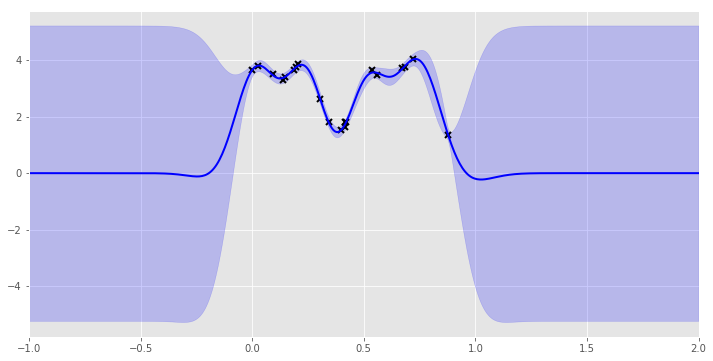

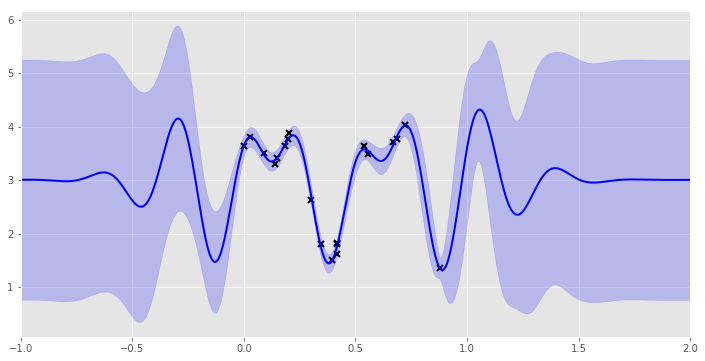

In [75]:
# data
np.random.seed(1)
N = 20
X = np.random.rand(N,1)
Y = np.sin(12*X) + 0.66*np.cos(25*X) + np.random.randn(N,1)*0.1 + 3

# fit GP fit Gaussian kernel
kgauss = gpf.kernels.RBF( 1, lengthscales=0.3 )  # init lengthscale to 0.3
mg = gpf.models.GPR(X, Y, kern = kgauss )
mg.likelihood.variance = 0.01
mg.compile()
gpf.train.ScipyOptimizer().minimize(mg)

# fit GP with SM kernel
ksm = UnivariateSMkernel( Q = 3 )
ms = gpf.models.GPR(X, Y, kern = ksm )
ms.likelihood.variance = 0.01
ms.compile()
gpf.train.ScipyOptimizer().minimize(ms)

print(mg)
print(ms)

plotgp(mg, X, Y, -1, 2)
plotgp(ms, X, Y, -1, 2)


# Task 3: CO2 dataset

Let's apply the spectral kernel to the CO2 dataset. Below is a template code that (usually) fits the datasets correctly due to initialising the correct 1-year frequency for the model. It might take a few retries to find a good fit.

Install the 'sklearn' package using 'pip' as well.

a) Can you still learn the 1-year frequency if the initialisation is random? Why or whynot?

b) Visualise the optimised SM kernel using the 'plt.imshow' function. You need evaluate the kernel matrix with the dataset 'X' using the optimised parameters


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 561.905068
  Number of iterations: 106
  Number of functions evaluations: 165


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 561.905068
  Number of iterations: 106
  Number of functions evaluations: 165


                             class prior transform  trainable shape  \
GPR/kern/amplitudes      Parameter  None       +ve       True  (3,)   
GPR/kern/frequencies     Parameter  None       +ve       True  (3,)   
GPR/kern/lengthscales    Parameter  None       +ve       True  (3,)   
GPR/likelihood/variance  Parameter  None       +ve      False    ()   

                         fixed_shape  \
GPR/kern/amplitudes             True   
GPR/kern/frequencies            True   
GPR/kern/lengthscales           True   
GPR/likelihood/variance         True   

                                                                     value  
GPR/kern/amplitudes      [120128.34879907189, 0.00018781059818681495, 6...  
GPR/kern/frequencies                   [1e-06, 0.27757947766112445, 1e-06]  
GPR/kern/lengthscales    [0.0014758205527568887, 1e-06, 0.7830501908833...  
GPR/likelihood/variance                                                0.1  


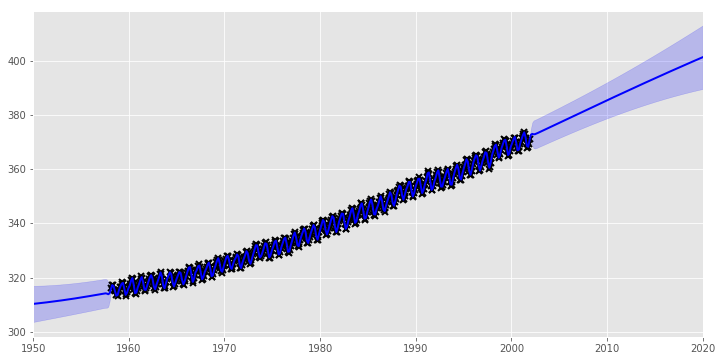

In [85]:

import sklearn
from sklearn.datasets import fetch_openml

def load_mauna_loa_atmospheric_co2():
    ml_data = fetch_openml(data_id=41187)
    months = []
    ppmv_sums = []
    counts = []

    y = ml_data.data[:, 0]
    m = ml_data.data[:, 1]
    month_float = y + (m - 1) / 12
    ppmvs = ml_data.target

    for month, ppmv in zip(month_float, ppmvs):
        if not months or month != months[-1]:
            months.append(month)
            ppmv_sums.append(ppmv)
            counts.append(1)
        else:
            # aggregate monthly sum to produce average
            ppmv_sums[-1] += ppmv
            counts[-1] += 1

    months = np.asarray(months).reshape(-1, 1)
    avg_ppmvs = np.asarray(ppmv_sums) / counts
    avg_ppmvs = np.asarray(avg_ppmvs).reshape(-1, 1)
    return months, avg_ppmvs


X, y = load_mauna_loa_atmospheric_co2()


# fit GP with SM kernel
ksm = UnivariateSMkernel( Q = 3, freqs = [0.05, 1.0, 0.5], ells = [0.01, 0.01, 0.01], amps = [20,20,20] )
ms = gpf.models.GPR(X, y, kern = ksm )
ms.likelihood.variance = 0.1
ms.likelihood.variance.trainable = False
ms.compile()
gpf.train.ScipyOptimizer().minimize(ms)

print(ms)

plotgp(ms, X, y, 1950., 2020.)


## Task 4: Demo of state space GP regression
1. In this exercise you start by first creating some dummy data by simulating a random function from a Matern nu=3/2 GP prior and then adding some Gaussian observation noise. 
2. The next step is to solve a GP regression task in order to recover the unknown latent function. This is done naively in the standard way by expanding the covariance matrix and inverting it (even though here we use the Cholesky factor to some additional stability, but still just using numpy). 
3. Finally the exactly same inference problem is solved sequentially by state space inference methods, and you are suposed to recover the _exactly_ same solution (within numerical precision), but now in O(n) time complexity rather than O(n^3).

Run the code (you will need to modify it in the next tasks). Feel free to experiment with the hyperparameters (magnitude, characteristic length-scale, and noise scale), and the number of data points, n. The larger your n, the larger the time difference between the two approaches.

In [79]:
import scipy.linalg as linalg
import time

In [80]:
# Parameters
n = 1000
sigma2 = 1
magnSigma2 = 1
ell = 1

In [81]:
# Helper function for plotting results
def plot_gp(t,f,y,Eft,Varft):
    plt.figure(figsize=(12, 6))
    plt.plot(t, f, 'k-', label=u'Hidden $f(t)$')
    plt.plot(t, y, 'r+', markersize=5, label=u'Observations')
    plt.plot(t, Eft, 'b-', label=u'Posterior mean')

    plt.fill(np.concatenate([t, t[::-1]]),
             np.concatenate([Eft - 1.96 * np.sqrt(Varft),
                            (Eft + 1.96 * np.sqrt(Varft))[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
    plt.xlabel('Input, $t$')
    plt.ylabel('Output, $y$')
    plt.legend()

Lik: 1441.333.
Naive GP inference took 0.570 s.


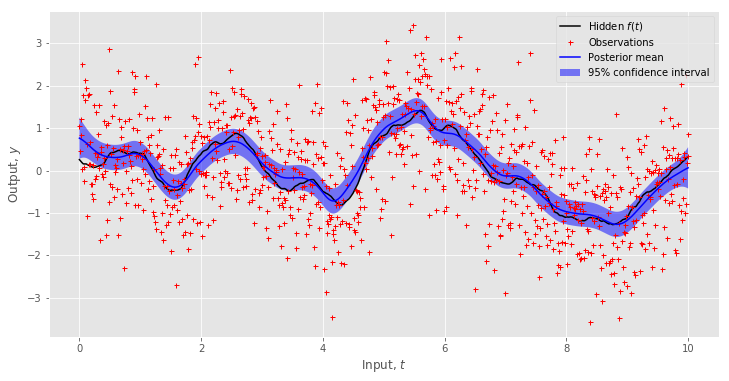

In [82]:
## Part 1: Simulate some data

# Observation time indices
t = np.linspace(0,10,n).reshape((n,1))

# Set up kernel (Matern nu=3/2)
tx,ty=np.meshgrid(t,t);
D = abs(tx-ty)
K = magnSigma2 * (1 + np.sqrt(3)*D/ell) * np.exp(-np.sqrt(3)*D/ell)

# Draw a random sample from the GP prior
np.random.seed(43)
L = np.linalg.cholesky(K)
f = L.dot(np.random.randn(n))
y = f + np.sqrt(sigma2)*np.random.randn(n)

## Part 2: Naive GP inference

# Start timing
start = time.process_time() 

# Solve the GP regression problem the naive way
alpha = np.linalg.solve(K+sigma2*np.eye(n), y)
L = np.linalg.cholesky(K+sigma2*np.eye(n))
v = np.linalg.solve(L, K)
Eft = K.dot(alpha) # Posterior mean
Varft = np.diag(K) - np.sum(v**2,axis=0) # Marginal variance

# Negative log marginal likelihood
negloglik = n/2*np.log(2*np.pi) + np.sum(np.log(np.diag(L))) + .5*y.T.dot(np.linalg.inv(K+sigma2*np.eye(n))).dot(y) #.5*y.T.dot(alpha)
print("Lik: %.3f." % negloglik) 

# End timing (this should grow O(n^3))
end = time.process_time()
print("Naive GP inference took %.3f s." % (end - start)) 

# Plot GP
plot_gp(t,f,y,Eft,Varft)

Lik: 0.000 (to be added in Task 5).
State space inference took 0.139 s.


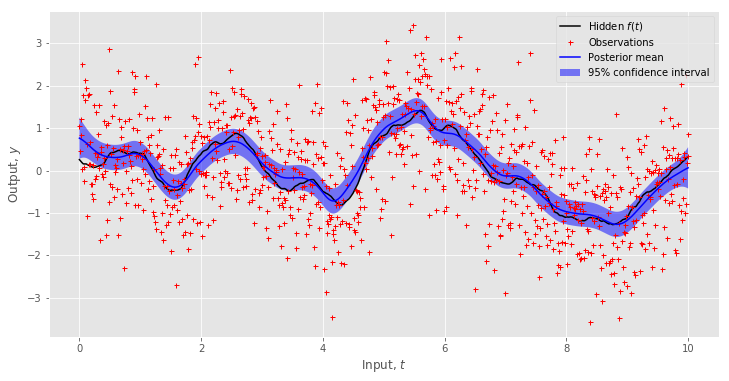

In [84]:
## Part 3: State space GP inference

# Define continuous-time state space model (SDE):
lam = np.sqrt(3)/ell;
F = np.array([[0,1],[-lam**2,-2*lam]])
Pinf = np.array([[magnSigma2,0],[0,magnSigma2*lam**2]])
h = np.array([[1],[0]])

# Solve the SDE for discrete time steps:
# The resulting state transition matrix and process noise covariance
dt = t[1]-t[0]
A = linalg.expm(F*dt)
Q = Pinf - A.dot(Pinf).dot(A.T)

# State mean and covariance
M = np.zeros((F.shape[0],n))
P = np.zeros((F.shape[0],F.shape[0],n))
P[:,:,0] = Pinf
negloglik = 0

# Start timing
start = time.process_time()

# Kalman filter (forward pass)
for i in range(0,y.shape[0]):
    # Prediction step
    if i > 0:
        M[:,i] = A.dot(M[:,i-1])
        P[:,:,i] = A.dot(P[:,:,i-1]).dot(A.T) + Q
    
    # Update step
    v = y[i]-h.T.dot(M[:,i])
    s = h.T.dot(P[:,:,i]).dot(h) + sigma2
    k = P[:,:,i].dot(h) / s
    M[:,i] += k.dot(v)
    P[:,:,i] -= k.dot(h.T).dot(P[:,:,i])
    
    # Update log likelihood (Task 5)
    negloglik += 0
        
# Report negative log marginal likelihood
print("Lik: %.3f (to be added in Task 5)." % negloglik) 
    
# Rauch-Tung-Striebel smoother (backward pass)
for i in range(y.shape[0]-2,-1,-1):
    Pp = A.dot(P[:,:,i]).dot(A.T) + Q
    G = np.linalg.solve(Pp, (P[:,:,i].dot(A.T)).T).T
    M[:,i] += G.dot(M[:,i+1]-A.dot(M[:,i]))
    P[:,:,i] += G.dot(P[:,:,i+1]-Pp).dot(G.T)

    Eft[i] = h.T.dot(M[:,i])
    Varft[i] = h.T.dot(P[:,:,i]).dot(h)

# End timing (this should grow O(n))
end = time.process_time()
print("State space inference took %.3f s." % (end - start)) 
    
# Plot GP
plot_gp(t,f,y,Eft,Varft)

## Task 5: Evaluating the marginal likelihood
Fill in the missing part inside the Kalman filter that evaluates the negative log marginal likelihood during the forward sweep. Look for the line with `negloglik += ?`. This quantity has to do with the so called innovation mean `v` and variance `s`. If you feel confused, look at the material in the lecture slides, or the two papers mentioned as pre-reading.

## Task 6: State space GPs with the exponential kernel
Copy-over the code from Task 4 above and modify the GP prior to use the exponential kernel instead of the Matern nu=3/2. This means that you need to define covariance function and define the matrices `F = -1/ell`, `h = 1`, and `Pinf = magnSigma2`. This stochastic differential equation is known as the Ornestein-Uhlenbeck process (see, e.g., discussion in Rasmussen and Williams, 2006, Appendix B).
After changing the model, make sure that you still get the same solution both ways.

## Additional fun (Not required)
1. Modify the above example in Task 4 to work for arbitrary input locations (now `t` was chosen equidistantly). You will need to move the solving of `A` and `Q` inside the for loop.
2. Modify the above example in Task 4 to predict at different points than where the data was observed. In practice, this only requires adding an `if` clause at the Kalman update.